# Simulation of option prices using the Black-Scholes model

## Simulations on CPU
### Compilation of files

In [2]:
import os
import subprocess

SRC_DIR = "src"
BUILD_DIR = "build"

FLAGS = ["-O3", "-march=native", "-std=c++14", "-fopenmp"]

# Find all .cpp files in the source dir
cpp_files = [] # will contain tuples like ("file.cpp", "file")
for file in os.listdir(SRC_DIR):
    file_name, file_extension = os.path.splitext(file)
    if file_extension == ".cpp":
        cpp_files.append((file, file_name))

# Compile each of the files
os.makedirs(BUILD_DIR, exist_ok=True)
for file_src, file_exe in cpp_files:
    file_src_path = os.path.join(SRC_DIR, file_src)
    file_build_path = os.path.join(BUILD_DIR, file_exe)
    
    command = ["g++", file_src_path, "-o", file_build_path] + FLAGS

    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if result.returncode == 0:
        print(f"Successfully compiled {file_src_path} to {file_build_path}")
    else:
        print(f"Error compiling {file_src_path}:\n{result.stderr}")


Successfully compiled src/monte_carlo_bs.cpp to build/monte_carlo_bs


### Execution

In [3]:
NUM_THREADS = (1,2,4,8,16)

for _, exe in cpp_files:
    exe_path = os.path.join(BUILD_DIR, exe)

    for num_threads in NUM_THREADS:
        command = [exe_path, "--num_threads", str(num_threads)]
        print(f"Executing {exe}... ", end="")
        result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        if result.returncode == 0:
            print("Success")
        else:
            print(f"ERROR : {result.stderr}")

Executing monte_carlo_bs... Success
Executing monte_carlo_bs... Success
Executing monte_carlo_bs... Success
Executing monte_carlo_bs... Success
Executing monte_carlo_bs... Success


### Plotting

/tmp/ipykernel_18698/3617995112.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left", fontsize="small", ncol=2)


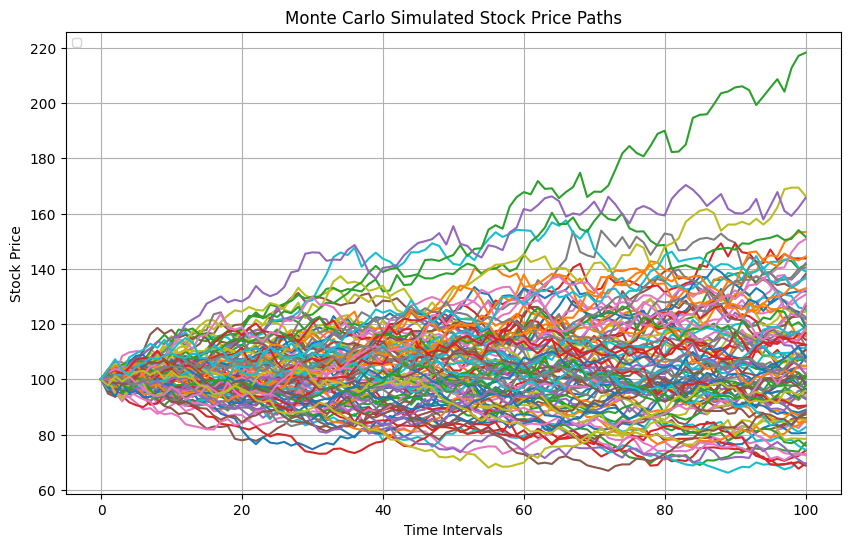

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd8 in position 96: invalid continuation byte

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

for csv in os.listdir(BUILD_DIR):
    csv_path = os.path.join(BUILD_DIR, csv)
    data = pd.read_csv(csv_path, header=None)

    plt.figure(figsize=(10, 6))
    for col in data.columns:
        plt.plot(data[col])
    
    plt.title("Monte Carlo Simulated Stock Price Paths")
    plt.xlabel("Time Intervals")
    plt.ylabel("Stock Price")
    plt.legend(loc="upper left", fontsize="small", ncol=2)
    plt.grid()
    plt.show()
